# Table of Contents
 <p><div class="lev1"><a href="#Imports"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></div><div class="lev1"><a href="#Analysis"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis</a></div><div class="lev2"><a href="#Linear-regression"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Linear regression</a></div><div class="lev3"><a href="#Model-comparison:"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Model comparison:</a></div><div class="lev2"><a href="#Ridge"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Ridge</a></div><div class="lev2"><a href="#Elastic-net"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Elastic net</a></div><div class="lev3"><a href="#Why-intercept==True"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Why <code>intercept==True</code></a></div><div class="lev2"><a href="#Elastic-net-CV"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Elastic net CV</a></div><div class="lev2"><a href="#Prediction"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Prediction</a></div><div class="lev3"><a href="#For-one-individual"><span class="toc-item-num">2.5.1&nbsp;&nbsp;</span>For one individual</a></div><div class="lev1"><a href="#Discriminant-Analysis"><span class="toc-item-num">3&nbsp;&nbsp;</span>Discriminant Analysis</a></div><div class="lev1"><a href="#PCA"><span class="toc-item-num">4&nbsp;&nbsp;</span>PCA</a></div><div class="lev1"><a href="#Hierarchical-clustering"><span class="toc-item-num">5&nbsp;&nbsp;</span>Hierarchical clustering</a></div><div class="lev2"><a href="#Single-method-linkage"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Single method linkage</a></div><div class="lev2"><a href="#Ward-method"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Ward method</a></div>

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as ss
%matplotlib inline

sns.set_style("ticks")

In [2]:
import statsmodels.formula.api as smf

In [3]:
from sklearn import linear_model

In [4]:
df2 = pd.read_table("data2.txt")

In [5]:
df2.head()

,x,y,gr,out,ind
1,1.343301,-2.359275,g1,0,True
2,4.590645,-0.287918,g1,0,True
3,0.763371,-1.182935,g1,0,True
4,1.326934,0.599838,g1,0,False
5,3.266690,3.259022,g1,0,False


# Analysis

## Linear regression

Seaborn allows easy representation of the data as a function of a categorical one.

/Users/jcury/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


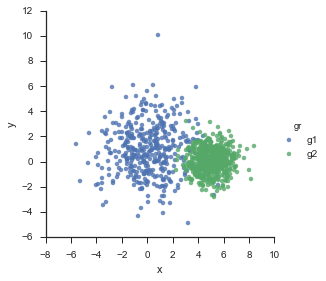

In [6]:
sns.lmplot("x", "y", hue="gr", data=df2, fit_reg=False, size=4)

Statsmodel allows to compute the linear regression by giving a formula like in R.

In [7]:
mod21 = smf.ols("out ~ x + y + ind", data=df2)

In [8]:
res21 = mod21.fit()

In [9]:
res21.params

Intercept      0.155266
ind[T.True]    0.011974
x              0.147227
y             -0.029118
dtype: float64

`res21.summary2()` will give the corresponding output as the summary(mod) from R at least for the p-values, `res21.summary()` will return slightly different values, I don't know why.

In [10]:
res21.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.747    
Dependent Variable: out              AIC:                40.9881  
Date:               2016-06-02 22:00 BIC:                60.6191  
No. Observations:   1000             Log-Likelihood:     -16.494  
Df Model:           3                F-statistic:        984.7    
Df Residuals:       996              Prob (F-statistic): 2.27e-297
R-squared:          0.748            Scale:              0.060757 
-------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------
Intercept       0.1553    0.0144  10.7481  0.0000   0.1269   0.1836
ind[T.True]     0.0120    0.0156   0.7673  0.4431  -0.0187   0.0426
x               0.1472    0.0029  51.4289  0.0000   0.1416   0.1528
y              -0.0291    0.0051  -5.6567  0.0000  -0.0392  -0.0190
------------------------------------------------------------------
Omnibus:             116.893       Durbin-Watson:          1.501  
Prob(Omnibus):       0.000         Jarque-Bera (JB):       167.819
Skew:                -0.852        Prob(JB):               0.000  
Kurtosis:            4.062         Condition No.:          10     
==================================================================

"""

### Model comparison:

We want to compare 2 models of linear regression. We can compute a F score from the anova between one model and more complicated model. If the more complicated model is better the difference will be significant.

In [11]:
modxi = smf.ols("out ~ x + ind", data=df2)

In [12]:
resxi = modxi.fit()

In [15]:
f, p, d = res21.compare_f_test(resxi)
print "F = {:.2f}\npvalue = {:.3e}".format(f, p)

F = 32.00
pvalue = 2.016e-08


In that case, the more complicated model does improve the model. Which is nice as we saw that `y` coeffience had significant impact on the linear regression while `ind` not  

## Ridge

Un modèle linéaire cherche les coefficients qui minimisent la somme des résidus au carré du modèle. Cette mesure en soi n’est pas suffisante pour comparer des modèles, puisqu’elle conduirait à sélectionner systématiquement le modèle avec tous les facteurs, même si certains ne sont pas significatifs. On peut s’affranchir de cette limitation comme vu précédemment (calcul de F, score Cp de Mallow, ...).
Dans cette partie, nous verrons une autre façon de le faire. Il s’agit de la régression dite "de Ridge". Ici, on minimisera le critère suivant :

$$ C = RSS + \lambda \sum_k \beta_k^2$$

, où RSS est la somme des résidus au carré et les $\beta_k$ sont les coefficients du modèle.


In [16]:
Y = df2.out.values
X = df2.drop(["out", "gr"], axis=1).values

In [17]:
n_alphas = 200 # lambda in R
alphas = np.linspace(0, 2000, n_alphas)
clf = linear_model.Ridge()

coefs = []
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X, Y)
    coefs.append(clf.coef_)
coefs = np.array(coefs)
coefs = pd.DataFrame(coefs, columns=df2.drop(["out", "gr"], axis=1).columns)

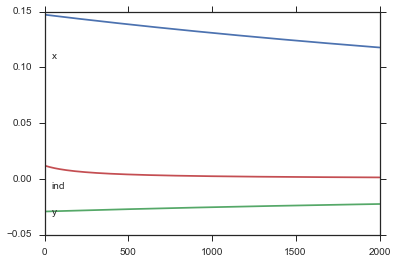

In [18]:
_ = plt.plot(alphas, coefs)
for c, name in zip(coefs.iloc[-1,:], coefs.columns):
    plt.text(45, c-0.01, name )

## Elastic net

Here, it's weird, I don't get the correct values in the graph, as `ind` seems to have an importance when Ridge and linear regression seems to give it no importance. My guess is that there si a bug with the fit_intercet which seems to be stuck at false. When we se it to false with ElasticnetCV and Ridge, it gives the same weird result (`ind` having some importance).
It was working on `data1.txt` though. I let it here for the sake of the plot

### Why `intercept==True`

When set to True, it asks to return the final constant (intercept). One wants to set it to `False` only if the table contains a columns full of `1`s wich will serve as the final constant, because it will mimic $y = \beta \times 1$


In [19]:
alphas_enet, coefs_enet, _ = linear_model.enet_path(X, Y,
                                                    n_alphas=20, # nlambda in R
                                                    l1_ratio=0.2, # alpha in R
                                                    eps=1e-4, # lambda.min.ratio in R, default value =1e-4
                                                    )
coefs_enet = pd.DataFrame(coefs_enet.T, columns=df2.drop(["out", "gr"], axis=1).columns)

(-3.2, 1.5)

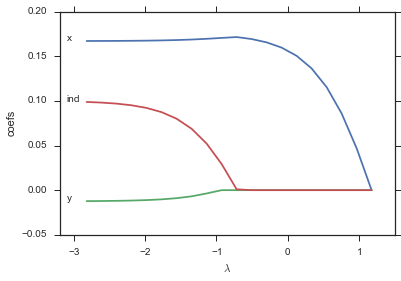

In [20]:
_ = plt.plot(np.log10(alphas_enet), coefs_enet)
for c, name in zip(coefs_enet.iloc[-1,:], coefs_enet.columns):
    plt.text(-3.1, c, name )
plt.xlabel("$\lambda$")
plt.ylabel("coefs")
#plt.ylim(-0.5,3.5)
plt.xlim(-3.2, 1.5)

## Elastic net CV

This works. It performs a K-fold cross validation with k=10 here (`cv=10`), and returns the best coefficients after cross validation after `elnet_CV.fit()`.

Beware of the different naming between `glmnet` and `sklearn`:

- `l1_ratio` $\rightarrow \alpha$ 
- `alpha` $\rightarrow \lambda$ 
- `eps` $\rightarrow$ lambda.min.ratio, default value in Python: $10^{-3}$, in R: $10^{-4} $

***When I'll write alpha, it will refer to the python parameters, so lambda in R.***

In [21]:
elnet_CV = linear_model.ElasticNetCV(l1_ratio=0.2, # alpha in R
                                   n_alphas=30, # nlambda in R
                                   eps=1e-4, # lambda.min.ratio in R, default value = 1e-4
                                   fit_intercept=True,
                                   cv=10)
alphas_enet_CV, coefs_enet_CV, _ = elnet_CV.path(X, Y)

In [22]:
reselnet_CV = elnet_CV.fit(X, Y)

As it returns the best coefficient the following graph is not really necessary. It may be useful if one wants to select another coef from another alpha whose mean square error is also small.

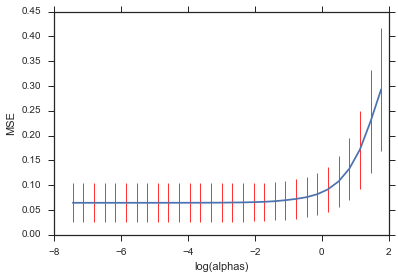

In [23]:
plt.errorbar(np.log(reselnet_CV.alphas_),
             reselnet_CV.mse_path_.mean(axis=1),
             yerr=reselnet_CV.mse_path_.std(axis=1),
            ecolor="r", elinewidth=0.8)
#_ = plt.xticks(np.log(reselnet_CV.alphas_)[::5], rotation=10)
_ = plt.ylabel("MSE")
_ = plt.xlabel("log(alphas)")

## Prediction

### For one individual

Say we want to (re-) predict the output for the individual 5 (or observation 5). We need to get the data for `x, y, ind` (we could remove ind and build a linear model without it). Then we need to add the intercept value estimated.

In [24]:
indiv_5 = df2.drop(["out", "gr"], axis=1).iloc[4].astype(float).values

In [25]:
mod21.predict(res21.params, [res21.params.loc["Intercept"]]+list(indiv_5)) 

0.54303852688793552

Which round up to 1, so this is bad prediction, 0 was expected ! But how do we behave on the entire dataset ?

In [26]:
df2["lm_pred"] = (res21.predict()>0.5).astype(int)

In [27]:
df2["elnet_pred"] = (elnet_CV.predict(X)>0.5).astype(int)

In [28]:
df2.head()

,x,y,gr,out,ind,lm_pred,elnet_pred
1,1.343301,-2.359275,g1,0,True,0,0
2,4.590645,-0.287918,g1,0,True,1,1
3,0.763371,-1.182935,g1,0,True,0,0
4,1.326934,0.599838,g1,0,False,0,0
5,3.266690,3.259022,g1,0,False,1,1


Confusion matrix (or contingency matrix) for the linear model prediction.

In [29]:
pd.crosstab(df2.out, df2.lm_pred)

lm_pred,0,1
out,,
0,356,44
1,1,599


Confusion matrix (or contingency matrix) for the elastic net CV model prediction.

In [30]:
pd.crosstab(df2.out, df2.elnet_pred)

elnet_pred,0,1
out,,
0,356,44
1,1,599


We can calculate the boundary line between the 2 groups by solving:

$$ C + \beta_1 X + \beta_2 y = 0.5 $$ 

Which correspond to:
$$y = -\frac{\beta_1}{\beta_2} X + \frac{0.5-C}{\beta_2} $$


In [31]:
intercept_lm = (0.5 - res21.params.loc["Intercept"]) / res21.params.loc["y"]
slope_lm = - res21.params.loc["x"] / res21.params.loc["y"]

xf = np.linspace(-2, 6, 100)
yf = slope_lm * xf + intercept_lm

In [32]:
intercept_elnet = (0.5 - elnet_CV.intercept_) / elnet_CV.coef_[1]
slope_elnet = - elnet_CV.coef_[0] / elnet_CV.coef_[1]

xf_e = np.linspace(-2, 6, 100)
yf_e = slope_elnet * xf + intercept_elnet

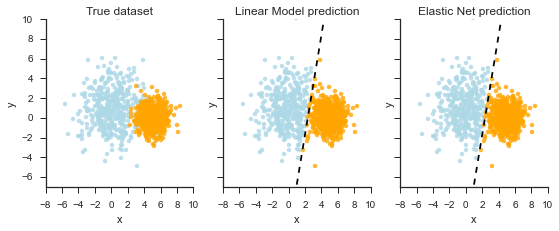

In [33]:
fig, ax = plt.subplots(1,3, figsize=(9,3), sharey=True, sharex=True)
sns.regplot("x", "y", data=df2[df2.out==0], fit_reg=0, ax=ax[0], color="lightblue")
sns.regplot("x", "y", data=df2[df2.out==1], fit_reg=0, ax=ax[0], color="orange")
ax[0].set_ylim(-7,10)
ax[0].set_title("True dataset")

sns.regplot("x", "y", data=df2[df2.lm_pred==0], fit_reg=0, ax=ax[1], color="lightblue")
sns.regplot("x", "y", data=df2[df2.lm_pred==1], fit_reg=0, ax=ax[1], color="orange")
ax[1].plot(xf, yf, "k--")
ax[1].set_ylim(-7,10)
ax[1].set_title("Linear Model prediction")

sns.regplot("x", "y", data=df2[df2.elnet_pred==0], fit_reg=0, ax=ax[2], color="lightblue")
sns.regplot("x", "y", data=df2[df2.elnet_pred==1], fit_reg=0, ax=ax[2], color="orange")
ax[2].plot(xf, yf, "k--")
ax[2].set_ylim(-7,10)
_ = ax[2].set_title("Elastic Net prediction")

sns.despine()

# Discriminant Analysis

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [35]:
def confusion_matrix(y_test, y_pred):
    df = pd.DataFrame() 
    df["y_test"] = y_test
    df["y_pred"] = y_pred
    cm =pd.crosstab(df.y_test, df.y_pred)
    cm.columns.name = 'Predicted label'
    cm.index.name = 'True label'
    error_rate = (y_pred != y_test).mean()
    #print('error rate: %.2f' % error_rate*100)
    return error_rate, cm

In [36]:
from sklearn.cross_validation import train_test_split

In [37]:
def disc_analysis(est, xx, yy, df_train, df_test, cv=20, print_cm=False):
    """ 
    est: like LDA(), QDA()
    X: columns name in df
    Y: column name in df
    df_train: the training dataset 
    df_test: the testing dataset
    cv: percentage of dataset not used in the model
    """
    
    X_train = df_train[xx]
    y_train = df_train[yy]
    X_test = df_test[xx]
    y_test = df_test[yy]

    est.fit(X_train, y_train)
    error_rate, cm = confusion_matrix(y_test, est.predict(X_test))
    if print_cm:
        print cm
    return error_rate

In [38]:
df2["x2"] = df2.x**2
df2["y2"] = df2.y**2
df2["xy"] = df2.x*df2.y

To compare the models we need to compute the error rate on the same training and testing dataset.

In [39]:
df2_train, df2_test = train_test_split(df2, test_size=0.20)

We make 1000 iterations which will be sufficient to pick the best model by just taking the one with the smallest error rate on average. If it takes too long one needs to verify that the the variance is not too big.

In [44]:
err_lda = []
err_qda = []
err_lda_2 = []
err_qda_2 = []
err_lda_all = []
err_qda_all = []

for i in range(100):
    err_lda.append(disc_analysis(LDA(), ["x", "y"], "out", df2_train, df2_test))
    err_qda.append(disc_analysis(QDA(), ["x", "y"], "out", df2_train, df2_test))
    # Taking into account only the square values has interest only if it means something.
    err_lda_2.append(disc_analysis(LDA(), ["x2", "y2"], "out", df2_train, df2_test)) 
    err_qda_2.append(disc_analysis(QDA(), ["x2", "y2"], "out", df2_train, df2_test))
    # This is polynomial extension of the model as one can do with the linear model
    err_lda_all.append(disc_analysis(LDA(), ["x", "y", "x2", "y2", "xy"], "out", df2_train, df2_test))
    err_qda_all.append(disc_analysis(QDA(), ["x", "y", "x2", "y2", "xy"], "out", df2_train, df2_test))
 

In [45]:
for i,name in zip([err_lda, err_qda, err_lda_2, err_qda_2, err_lda_all, err_qda_all],
                   ["lda", "qda", "lda_2", "qda_2", "lda_all", "qda_all"]):
    print "With {} model, error rate is {} % and variance is {:.1e}".format(name, np.mean(i)*100, np.var(i))

With lda model, error rate is 5.0 % and variance is 1.9e-34
With qda model, error rate is 3.0 % and variance is 0.0e+00
With lda_2 model, error rate is 4.0 % and variance is 4.8e-35
With qda_2 model, error rate is 6.0 % and variance is 0.0e+00
With lda_all model, error rate is 3.5 % and variance is 1.9e-34
With qda_all model, error rate is 2.5 % and variance is 4.8e-35


# PCA

In [46]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

In [47]:
iris = load_iris()

In [48]:
iris.keys()

['target_names', 'data', 'target', 'DESCR', 'feature_names']

In [49]:
pca = PCA(n_components=2)

In [50]:
X = iris.data
y = iris.target

Fit with dimensionality reduction :

In [51]:
X_pca = pca.fit_transform(X)

In [52]:
df_pca = pd.DataFrame(X_pca)
df_pca['name'] = [iris.target_names[i] for i in iris.target] 
df_pca.columns = [['pc1', 'pc2', 'y']]
df_pca.head()

,pc1,pc2,y
0,-2.684207,-0.326607,setosa
1,-2.715391,0.169557,setosa
2,-2.889820,0.137346,setosa
3,-2.746437,0.311124,setosa
4,-2.728593,-0.333925,setosa


The following graph is a biplot, where:
> Samples are displayed as points while variables are displayed either as vectors, linear axes or nonlinear trajectories. In the case of categorical variables, category level points may be used to represent the levels of a categorical variable. A generalised biplot displays information on both continuous and categorical variables.
[Wikipedia](https://en.wikipedia.org/wiki/Biplot)

Here samples are the different iris, and the variable, their cracteristics.

This is useful, as one can evaluate (here) the biological value of the plante, by projecting one sample on the corresponding line going through the vector.

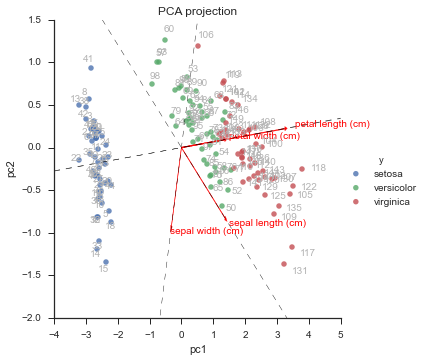

In [53]:
sns.lmplot('pc1', 'pc2', data=df_pca,
           hue = 'y',
           fit_reg = False,
           size = 5,
           scatter_kws={"s": 30})

# set the maximum variance of the first two PCs
# this will be the end point of the arrow of each **original features**
xvector = pca.components_[0]
yvector = pca.components_[1]
 
# value of the first two PCs, set the x, y axis boundary
xs = pca.transform(X)[:,0]
ys = pca.transform(X)[:,1]

x = np.linspace(-4,5,10)

## visualize projections
for i in range(len(xvector)):
    # arrows project features (ie columns from csv) as vectors onto PC axes
    # we can adjust length and the size of the arrow
    plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
              color='r', width=0.01, head_width=0.05)
    plt.text(xvector[i]*max(xs)*1.1, yvector[i]*max(ys)*1.1,
             list(iris.feature_names)[i], color='r')
    plt.plot(x, x*((yvector[i]*max(ys))/(xvector[i]*max(xs))), "k--", lw=0.4)

# Annotate dots
# not very informative here !
for i in range(len(xs)):
    plt.text(xs[i]*1.08, ys[i]*1.08, i, color='0.7') # index number of each observations

plt.ylim(-2,1.5)
plt.xlim(-4,5)
_ = plt.title("PCA projection")
# If one wants to center the spine (axes) at zero.
# 
# ax = plt.gca()
# ax.spines['left'].set_position('zero')
# ax.spines['right'].set_color('none')
# ax.spines['bottom'].set_position('zero')
# ax.spines['top'].set_color('none')
# ax.spines['left'].set_smart_bounds(True)
# ax.spines['bottom'].set_smart_bounds(True)


# Hierarchical clustering

Need to write some explanation...

In [54]:
import scipy.cluster.hierarchy as sch
from sklearn.metrics.pairwise import euclidean_distances

## Single method linkage

In [55]:
dist = euclidean_distances(X)
L = sch.linkage(dist)

/Users/jcury/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/scipy/spatial/distance.py:1176: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dm = np.zeros((m * (m - 1) / 2,), dtype=np.double)


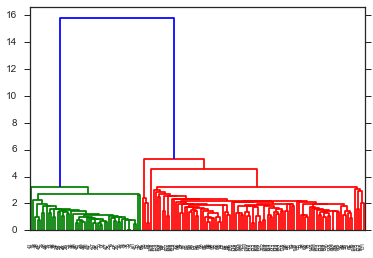

In [56]:
_ = sch.dendrogram(L)

## Ward method 

One needs to pass the X matrix directly without calculating the euclidean distance. (not working otherwise !)

from docstring: 

> Alternatively, a collection of
> `m` observation vectors in `n` dimensions may be passed as an
> `m` by `n` array.

In [57]:
L = sch.linkage(X, method='ward')

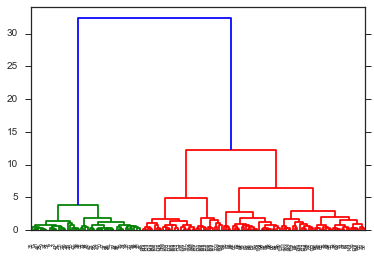

In [58]:
_ = sch.dendrogram(L)